In [2]:
from functools import partial
import math
import urllib
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
import torchvision
from torchvision import datasets, transforms

# Useful functions and Loading of the dataset

In [3]:
def load():
    """ Load training dataset and convert 'b' into 0 and 's' into 1
        Remove the 24th categorical feature
        Return the dataset and the removed feature """
   
    X_2 = np.genfromtxt("X_2.csv", delimiter=",")
    Y_2 = np.genfromtxt("Y_2.csv", delimiter=",")
    Fx_2 = np.genfromtxt("FX_2.csv", delimiter=",")
    Fy_2 = np.genfromtxt("FY_2.csv", delimiter=",")
    
    X_3 = np.genfromtxt("X_3.csv", delimiter=",")
    Y_3 = np.genfromtxt("Y_3.csv", delimiter=",")
    Fx_3 = np.genfromtxt("FX_3.csv", delimiter=",")
    Fy_3 = np.genfromtxt("FY_3.csv", delimiter=",")
    
    return X_2.T, Y_2.T, Fx_2.T, Fy_2.T, X_3.T, Y_3.T, Fx_3.T, Fy_3.T

###############################################################################

def distance_from_rotor(X, Y):
    R = 0.5
    r = np.sqrt(X**2 + Y**2)
    return R - r

###############################################################################

In [4]:
# loading data
X_2, Y_2, Fx_2, Fy_2, X_3, Y_3, Fx_3, Fy_3 = load()

N1 = X_2.shape[0]
N2 = X_3.shape[0]
D = X_2.shape[1]

In [5]:
def create_dataset_3feat(N, D, dd, X, Y, dist, Fx, Fy):
    
    df_input = np.zeros((N*(D-dd), dd*3))
    df_output = np.zeros((N*(D-dd), 2))
    i = 0

    for t in tqdm.tqdm(range(N)):
    
        for n in range(D-dd):

            row = np.zeros(dd*3)

            for d in range(dd):
            
                row[3*d] = X[t, n+d]
                row[3*d + 1] = Y[t, n+d]
                row[3*d + 2] = dist[t, n+d]
        
            df_input[i, :] = row
            df_output[i, :] = np.array([Fx[t, n+dd], Fy[t, n+dd]])
            i = i+1
    
    return df_input, df_output

#################################################################################

def create_dataset_3feat_onetraj(D, dd, X, Y, dist, Fx, Fy):
    
    df_input = np.zeros((D-dd, dd*3))
    df_output = np.zeros((D-dd, 2))
    i = 0

    for n in range(D-dd):
        
        row = np.zeros(dd*3)

        for d in range(dd):
            
            row[3*d] = X[n+d]
            row[3*d + 1] = Y[n+d]
            row[3*d + 2] = dist[n+d]
        
        df_input[i, :] = row
        df_output[i, :] = np.array([Fx[n+dd], Fy[n+dd]])
        i = i+1
    
    return df_input, df_output


In [6]:
def merge_datasets_robustness(df2, df3, n_train):
    
    # df2.shape[0] = 450
    # df3.shape[0] == 1800
    # 9 sets of parameters
    
    n2 = int(df2.shape[0]/9) # == 50
    n3 = int(df3.shape[0]/9) # == 200
    NN = n2 + n3
    D = df2.shape[1] # == 2001 == df3.shape[1]
    
    df_train = np.zeros((n_train*9, D))
    df_test = np.zeros((((n2+n3)-n_train)*9, D))
    
    for i in range(9):
        df_train[i*n_train : (i+1)*n_train, :] = df3[n3*i : (n3*i+n_train), :]
        df_test[i*(NN-n_train):(i+1)*(NN-n_train), :]=np.r_[df3[(n3*i+n_train):(i+1)*n3, :], df2[i*n2:(i+1)*n2, :]]
     
    return df_train, df_test

In [7]:
n_train = 180
X, X_to_test = merge_datasets_robustness(X_2, X_3, n_train)
Y, Y_to_test = merge_datasets_robustness(Y_2, Y_3, n_train)
Fx, Fx_to_test = merge_datasets_robustness(Fx_2, Fx_3, n_train)
Fy, Fy_to_test = merge_datasets_robustness(Fy_2, Fy_3, n_train)

dist = distance_from_rotor(X, Y)
dist_to_test = distance_from_rotor(X_to_test, Y_to_test)

N = X.shape[0]
D = X.shape[1]

In [8]:
def random_permutation(df_input, df_output):

    N = df_input.shape[0]
    shuffle_indices = np.random.permutation(np.arange(N))
    df_in_shuff = df_input[shuffle_indices]
    df_out_shuff = df_output[shuffle_indices]

    return df_in_shuff, df_out_shuff


In [9]:
def tensorize(df_in_shuff, df_out_shuff):

    df_input_tensor = torch.Tensor(df_in_shuff)
    df_output_tensor = torch.Tensor(df_out_shuff)

    return df_input_tensor, df_output_tensor


In [10]:
def split_train_val(df_input_tensor, df_output_tensor, p):
  
    # Take the first p% of the dataset as training set and (1-p)% as validation set
    N = df_input_tensor.shape[0]
    df_in_train = df_input_tensor[:int(N*p), :]
    df_in_valid = df_input_tensor[int(N*p):, :]

    df_out_train = df_output_tensor[:int(N*p), :]
    df_out_valid = df_output_tensor[int(N*p):, :]

    return df_in_train, df_in_valid, df_out_train, df_out_valid


In [11]:
dd = 100
p = 0.9

df_input, df_output = create_dataset_3feat(N, D, dd, X, Y, dist, Fx, Fy)
df_in_shuff, df_out_shuff = random_permutation(df_input, df_output)
df_input_tensor, df_output_tensor = tensorize(df_in_shuff, df_out_shuff)
df_in_train, df_in_valid, df_out_train, df_out_valid = split_train_val(df_input_tensor, df_output_tensor, p)

train = torch.utils.data.TensorDataset(df_in_train, df_out_train)
test = torch.utils.data.TensorDataset(df_in_valid, df_out_valid) #VALIDATION

# Didn't change name not to change everything afterwords

100%|██████████████████████████████████████████████████████████████████████████████| 1620/1620 [05:13<00:00,  5.16it/s]


In [12]:
class Aerospace_Bearing_FNN(torch.nn.Module):
    # Models in PyTorch usually inherit from this Module
    def __init__(self, feat, d, hidden1, hidden2, hidden3):
        super().__init__()
        
        self.input_layer = torch.nn.Linear(feat*d, hidden1)
        self.input_phi = torch.nn.ReLU()
        self.layer1 = torch.nn.Linear(hidden1, hidden2)
        self.phi1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(hidden2, hidden3)
        self.phi2 = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(hidden3, 2)

    def forward(self, Z):
        # Z = torch.flatten(Z, 1)  # Flatten (n, 28, 28) to (n, 784)
        Z = self.input_layer(Z)
        Z = self.input_phi(Z)
        Z = self.layer1(Z)
        Z = self.phi1(Z)
        Z = self.layer2(Z)
        Z = self.phi2(Z)
        Z = self.output_layer(Z)

        return Z

In [13]:
def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    
    # Set model to training mode (affects dropout, batch norm e.g.)
    model.train()
    loss_history = []
    accuracy_history = []
    lr_history = []
    
    # Change the loop to get batch_idx, data and target from train_loader
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # Move the data to the device
        data = data.to(device)
        target = target.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute model output
        output = model(data)
        
        # Compute loss
        loss = criterion(output, target)
        
        # Backpropagate loss
        loss.backward()
        
        # Perform an optimizer step
        optimizer.step()
        
        # Perform a learning rate scheduler step
        scheduler.step()

        # Compute loss_float (float value, not a tensor)
        loss_float = loss.item()

        # Add loss_float to loss_history
        loss_history.append(loss_float)

        lr_history.append(scheduler.get_last_lr()[0])
        if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx:03d} "
                f"batch_loss={loss_float:0.2e} "
                # f"batch_acc={accuracy_float:0.3f} "
                f"lr={scheduler.get_last_lr()[0]:0.3e} "
            )

    return loss_history, lr_history


@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    test_loss = 0
    
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item() * len(data)
        
    test_loss /= len(val_loader.dataset)

    print(
        "Test set: Average loss: {:.4f}".format(test_loss)
    )
    return test_loss


@torch.no_grad()
def get_predictions(model, device, val_loader, criterion, num=None):
    model.eval()
    points = []
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        
        data = np.split(data.cpu().numpy(), len(data))
        loss = np.split(loss.cpu().numpy(), len(data))
        target = np.split(target.cpu().numpy(), len(data))
        
        points.extend(zip(data, loss, target))

        if num is not None and len(points) > num:
            break

    return points


def run_aerobearing_training(feat, ddd, hidden1, hidden2, hidden3, num_epochs, lr, batch_size, device="cpu"):
    # ===== Data Loading =====
    transform = transforms.ToTensor()
    train_set = train
    val_set = test

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=False,  # Can be important for training
        pin_memory=torch.cuda.is_available(),
        drop_last=False,
        num_workers=2,
    )

    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size,
    )

    # ===== Model, Optimizer and Criterion =====

    model = Aerospace_Bearing_FNN(feat, ddd, hidden1, hidden2, hidden3)
    model = model.to(device=device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    criterion = torch.nn.functional.mse_loss
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size)
    
    # ===== Train Model =====
    lr_history = []
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(1, num_epochs + 1):
        train_loss, lrs = train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device)
        train_loss_history.extend(train_loss)
        lr_history.extend(lrs)

        val_loss = validate(model, device, val_loader, criterion)
        val_loss_history.append(val_loss)
        
    # ===== Plot training curves =====
    n_train = len(train_loss_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)

    plt.figure()
    plt.plot(t_train, train_loss_history, label="Train")
    plt.plot(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.figure()
    plt.plot(t_train, lr_history)
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")

    return model

Train Epoch: 1-000 batch_loss=3.11e+00 lr=1.000e-02 
Train Epoch: 1-568 batch_loss=5.73e-02 lr=9.998e-03 
Train Epoch: 1-1136 batch_loss=6.86e-02 lr=9.990e-03 
Train Epoch: 1-1704 batch_loss=6.43e-02 lr=9.978e-03 
Train Epoch: 1-2272 batch_loss=5.93e-02 lr=9.961e-03 
Train Epoch: 1-2840 batch_loss=2.36e-02 lr=9.939e-03 
Train Epoch: 1-3408 batch_loss=4.15e-02 lr=9.912e-03 
Train Epoch: 1-3976 batch_loss=2.66e-02 lr=9.880e-03 
Train Epoch: 1-4544 batch_loss=3.06e-02 lr=9.843e-03 
Train Epoch: 1-5112 batch_loss=5.75e-02 lr=9.802e-03 
Train Epoch: 1-5680 batch_loss=2.63e-02 lr=9.756e-03 
Test set: Average loss: 0.0463
Train Epoch: 2-000 batch_loss=3.85e-02 lr=9.755e-03 
Train Epoch: 2-568 batch_loss=3.24e-02 lr=9.704e-03 
Train Epoch: 2-1136 batch_loss=2.96e-02 lr=9.649e-03 
Train Epoch: 2-1704 batch_loss=3.29e-02 lr=9.589e-03 
Train Epoch: 2-2272 batch_loss=2.14e-02 lr=9.524e-03 
Train Epoch: 2-2840 batch_loss=1.87e-02 lr=9.455e-03 
Train Epoch: 2-3408 batch_loss=2.46e-02 lr=9.382e-03 
T

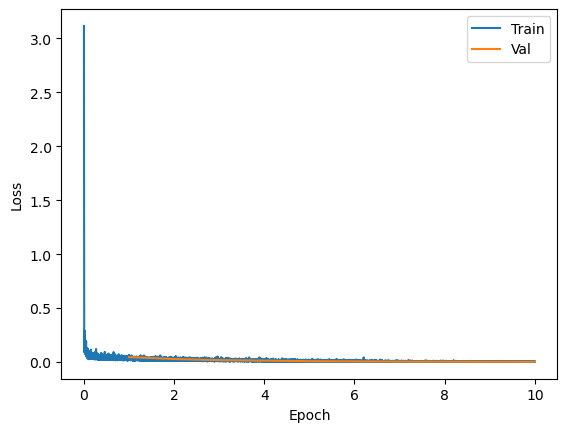

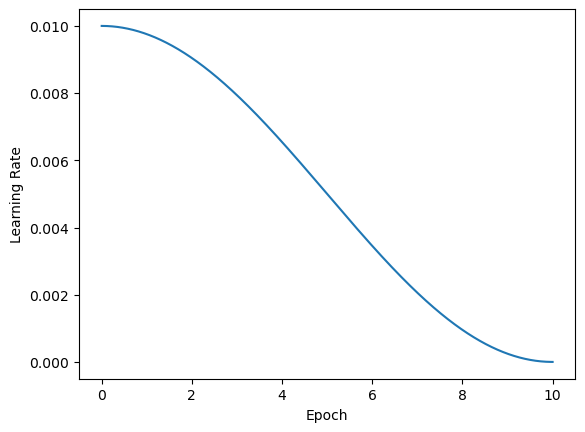

In [14]:
# TODO: Play around with these settings
lr = 0.01
batch_size = 500
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feat = 3
hidden1 = 256
hidden2 = 256
hidden3 = 64

model = run_aerobearing_training(feat, dd, hidden1, hidden2, hidden3, num_epochs, lr, batch_size, device)

In [15]:
def get_MSE(df_in_test_tensor, df_out_test_tensor):
    
    losses = []
    for i in tqdm.tqdm(range(len(df_in_test_tensor))):
        
        row = df_in_test_tensor[i, :]
        
        pred = model(row.to(device))
        pred = pred.to('cpu')
        
        loss = float(torch.mean((df_out_test_tensor[i, :]-pred)**2))
        losses.append(loss)
    
    mse = np.mean(losses)

    return losses, mse


In [ ]:
def get_RE(df_in_test_tensor, df_out_test_tensor):
    
    """ It computes the Relative Error (Absolute Error / Magnitude of the Output)
        between the prediction of the model and the true value of the output.
        In particular, the prediction of a given observation consists of
        the forces along x and y directions. Hence, the RE wrt to the
        actual value of the forces is computed and averaged over the two 
        directions: this is the error taken for a single observation.
        Then the mean over all samples is returned.
        R = number of rows and C = number of columns of the input
        
        Input: df_in_test_tensor = shape(R, C), float (Input Testing Set torch.Tensor)
               df_in_test_tensor = shape(R, 2), float (Output Testing Set torch.Tensor)
        
    """
    
    losses = []
    for i in tqdm.tqdm(range(len(df_in_test_tensor))):
        
        row = df_in_test_tensor[i, :]
        
        pred = model(row.to(device))
        pred = pred.to('cpu')
        
        loss = float(torch.mean(torch.abs(df_out_test_tensor[i, :]-pred)/df_out_test_tensor[i, :]))
        losses.append(loss)
    
    rel_err = np.mean(losses)

    return losses, rel_err


In [16]:
# create the dataset to test
nn = X_to_test.shape[0]
#dist_new = distance_from_rotor(X_new,Y_new)
df_in_test, df_out_test = create_dataset_3feat(nn, D, dd, X_to_test, Y_to_test, dist_to_test, Fx_to_test, Fy_to_test)
df_in_test_tensor, df_out_test_tensor = tensorize(df_in_test, df_out_test)

losses, mse = get_MSE(df_in_test_tensor, df_out_test_tensor)
losses_rel, rel_err = get_RE(df_in_test_tensor, df_out_test_tensor)


100%|███████████████████████████████████████████████████████████████████████| 1229130/1229130 [26:46<00:00, 765.09it/s]


0.0030451695549021983
1229130


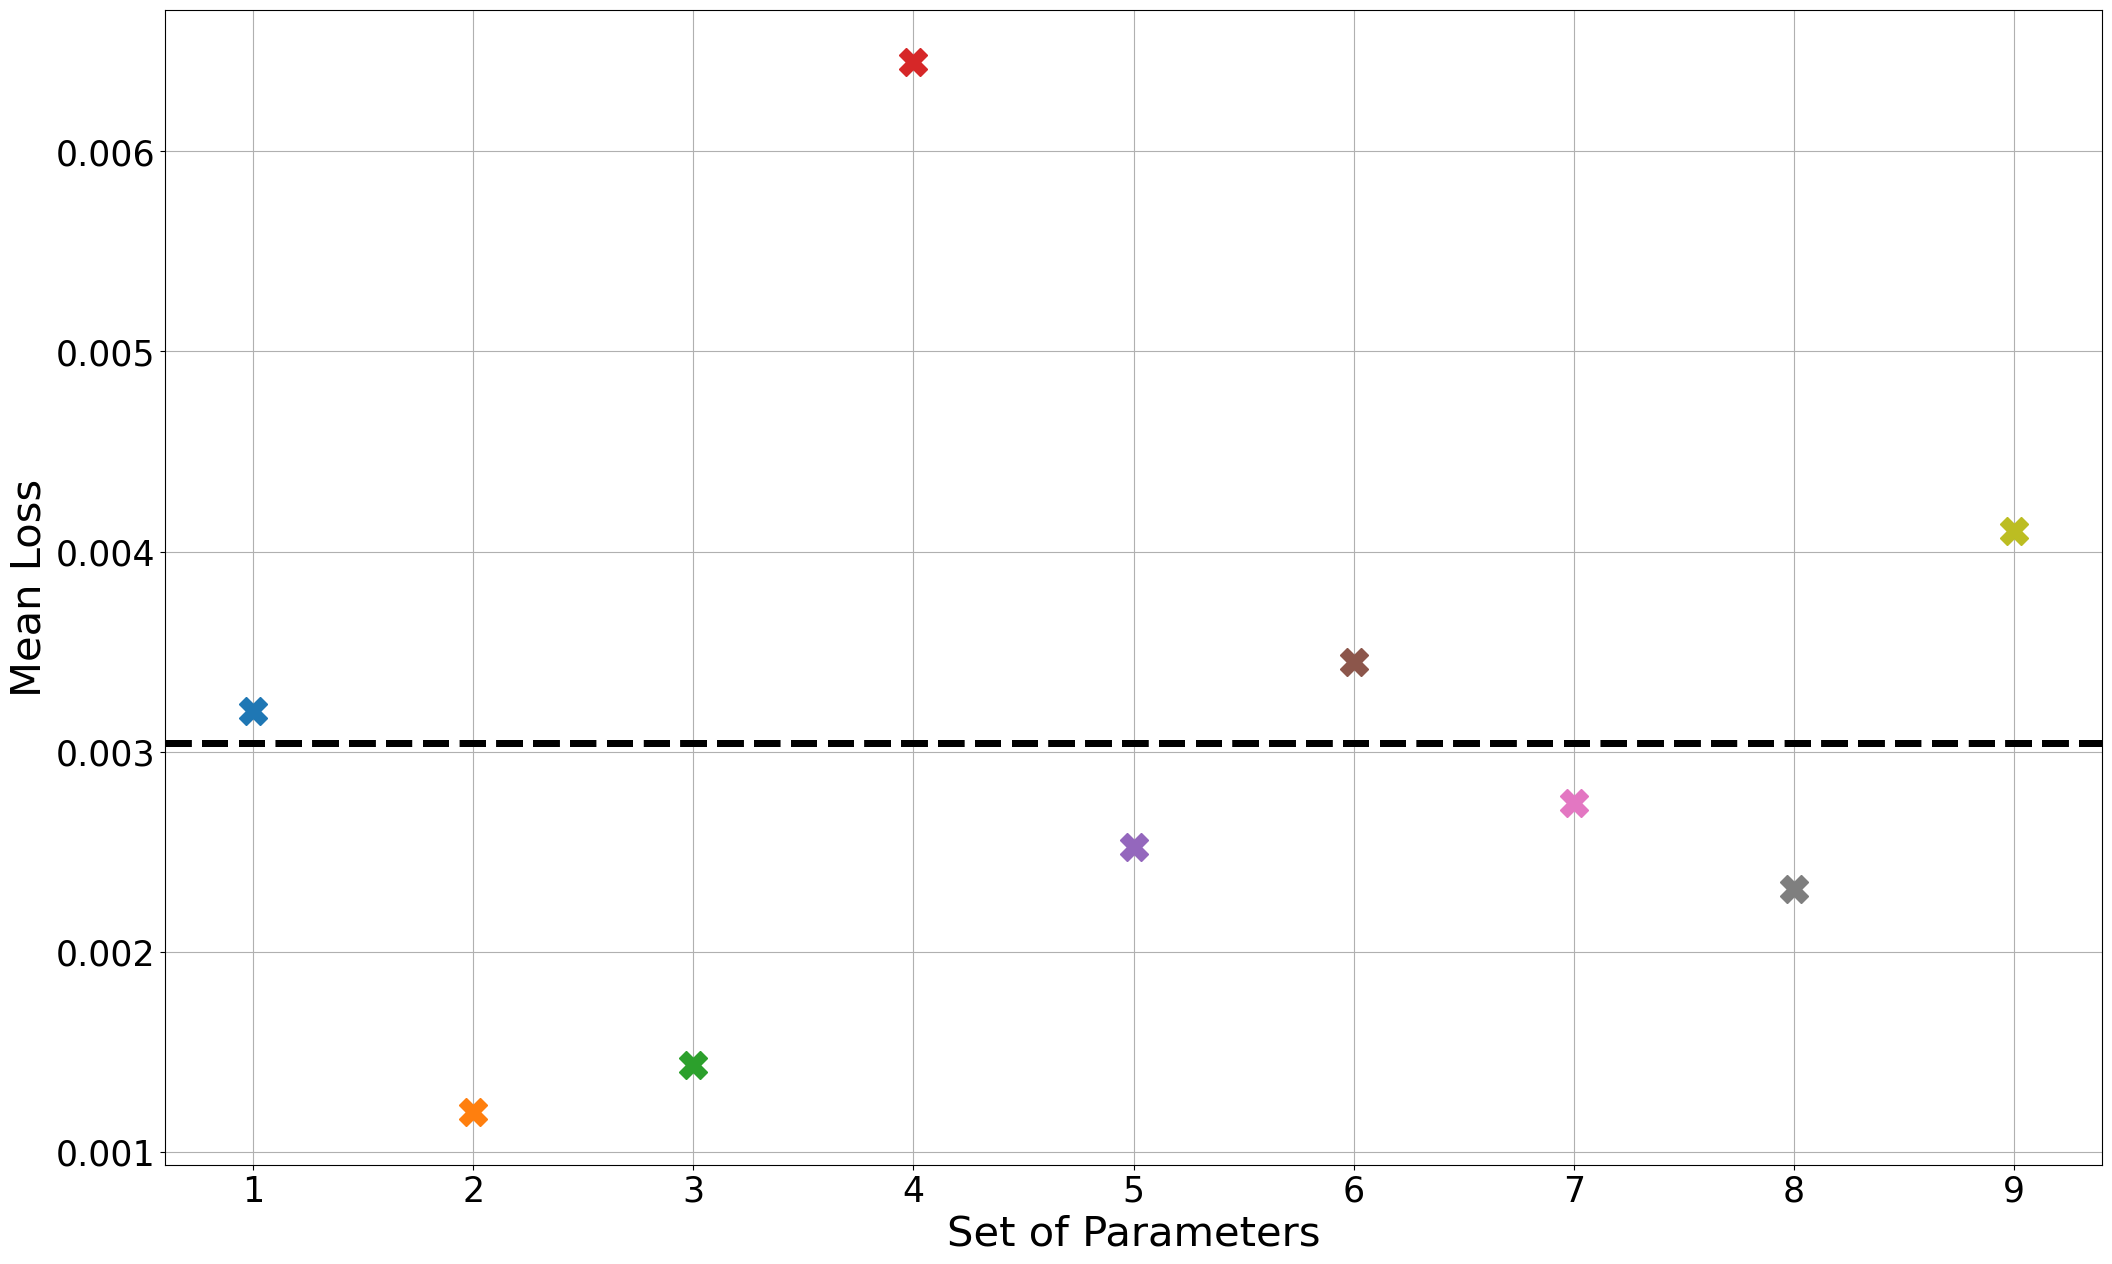

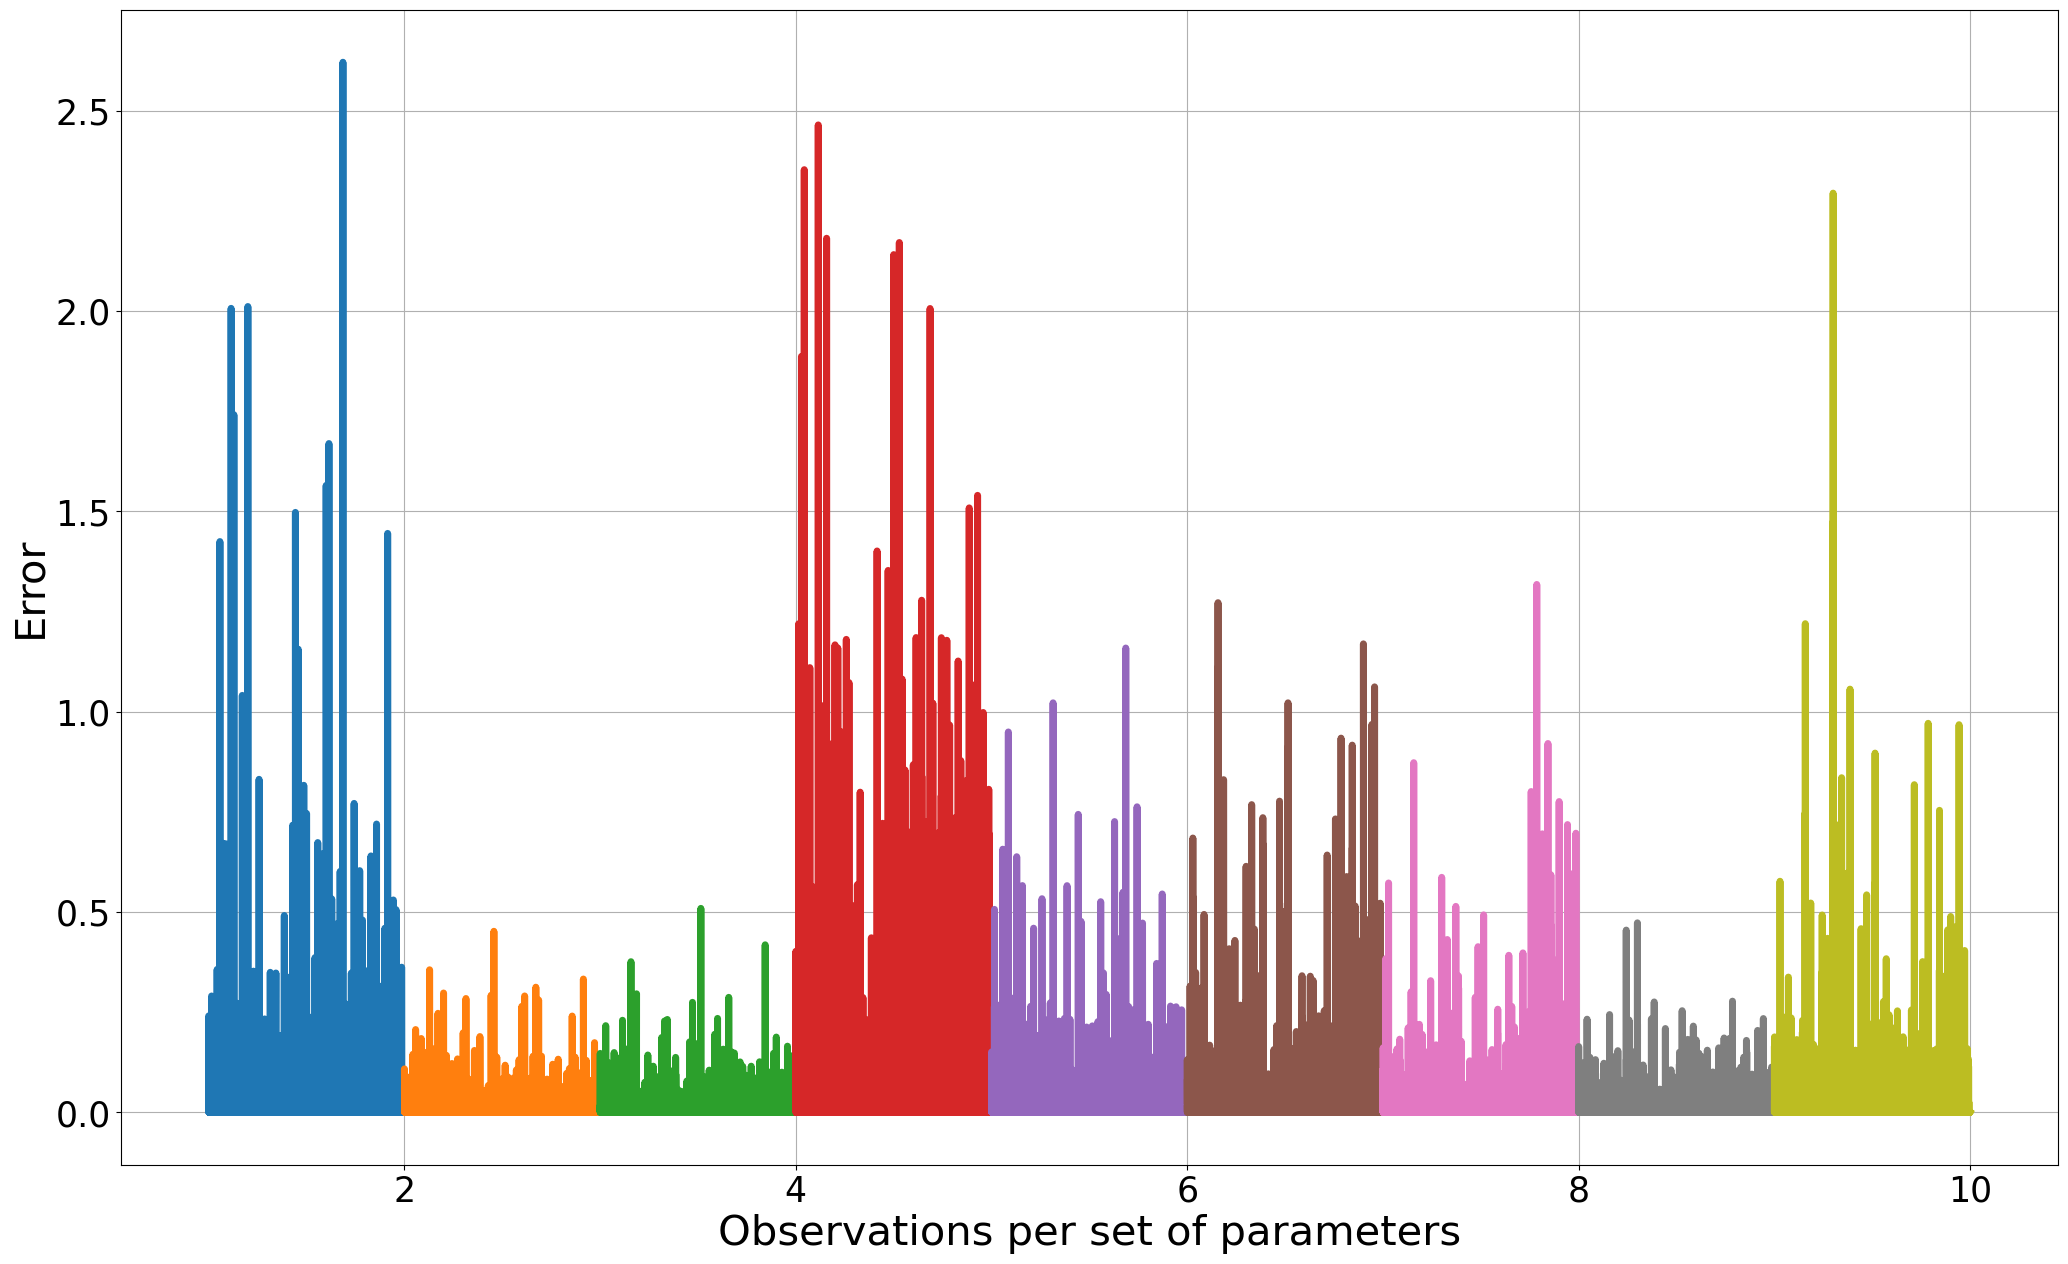

In [17]:
losses = np.asarray(losses)
losses_param = losses.reshape(9,-1)
print(mse)
print(len(losses))

##############################################################################
plt.figure(figsize=(25, 15))
for i in range(9):
    
    plt.plot(i+1,
             np.mean(losses_param[i]),
             marker="X",
             markersize=20,
             linestyle="None",
    #         color="blue",
    #         label="Predicted",
             linewidth=5,
            )
    
    plt.axhline(y = mse, color = 'k', linestyle = '--', linewidth=5)
    
plt.grid(True)
# plt.legend(fontsize=25)
plt.xlabel("Set of Parameters", fontsize=30)
plt.ylabel("Mean Loss", fontsize=30)

plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
plt.savefig("FNN_robustness_mean_errors.png")

#########################################################################################
plt.figure(figsize=(25, 15))
for i in range(9):
    obs_per_param = len(losses_param[i])
    plt.plot(np.arange(i*obs_per_param, (i+1)*obs_per_param)/obs_per_param + 1,
             losses_param[i],
    #         marker="X",
    #         markersize=20,
    #         linestyle="None",
    #         color="blue",
    #         label="Predicted",
             linewidth=5,
            )
    
plt.grid(True)
# plt.legend(fontsize=25)
plt.xlabel("Observations per set of parameters", fontsize=30)
plt.ylabel("Error", fontsize=30)

plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
plt.savefig("FNN_robustness_errors.png")


In [18]:
def plot_trajectory_coord(dd, traj):
  
    # save one trajectory to be plotted (tbp)
    tbp_X = X_to_test[traj,:]
    tbp_Y = Y_to_test[traj,:]
    tbp_Fx = Fx_to_test[traj,:]
    tbp_Fy = Fy_to_test[traj,:]
    tbp_d = dist_to_test[traj,:]
    
    traj_in, traj_out = create_dataset_3feat_onetraj(D, dd, tbp_X, tbp_Y, tbp_d, tbp_Fx, tbp_Fy)

    fx_pred_tbp = []
    fy_pred_tbp = []

    for i in range(len(traj_in)):
        row = torch.Tensor(traj_in[i,:])
        row = torch.unsqueeze(row,0)
        pred = model(row.to(device))
        fy_pred_tbp.append(float(pred[0][0]))
        fx_pred_tbp.append(float(pred[0][1]))

    plt.figure(figsize=(25, 15))
    
    plt.plot(fx_pred_tbp,
             fy_pred_tbp,
    #         marker="X",
    #         markersize=20,
    #         linestyle="None",
    #         color="blue",
             label="Predicted",
             linewidth=8,
            )

    plt.plot(traj_out[:,1],
             traj_out[:,0],
    #         marker="X",
    #         markersize=20,
    #         linestyle="None",
    #         color="blue",
             label="True",
             linewidth=8,
            )

    plt.grid(True)
    plt.legend(fontsize=25)
    plt.xlabel("F_x", fontsize=30)
    plt.ylabel("F_y", fontsize=30)

    plt.tick_params(axis='x', labelsize=25)
    plt.tick_params(axis='y', labelsize=25)


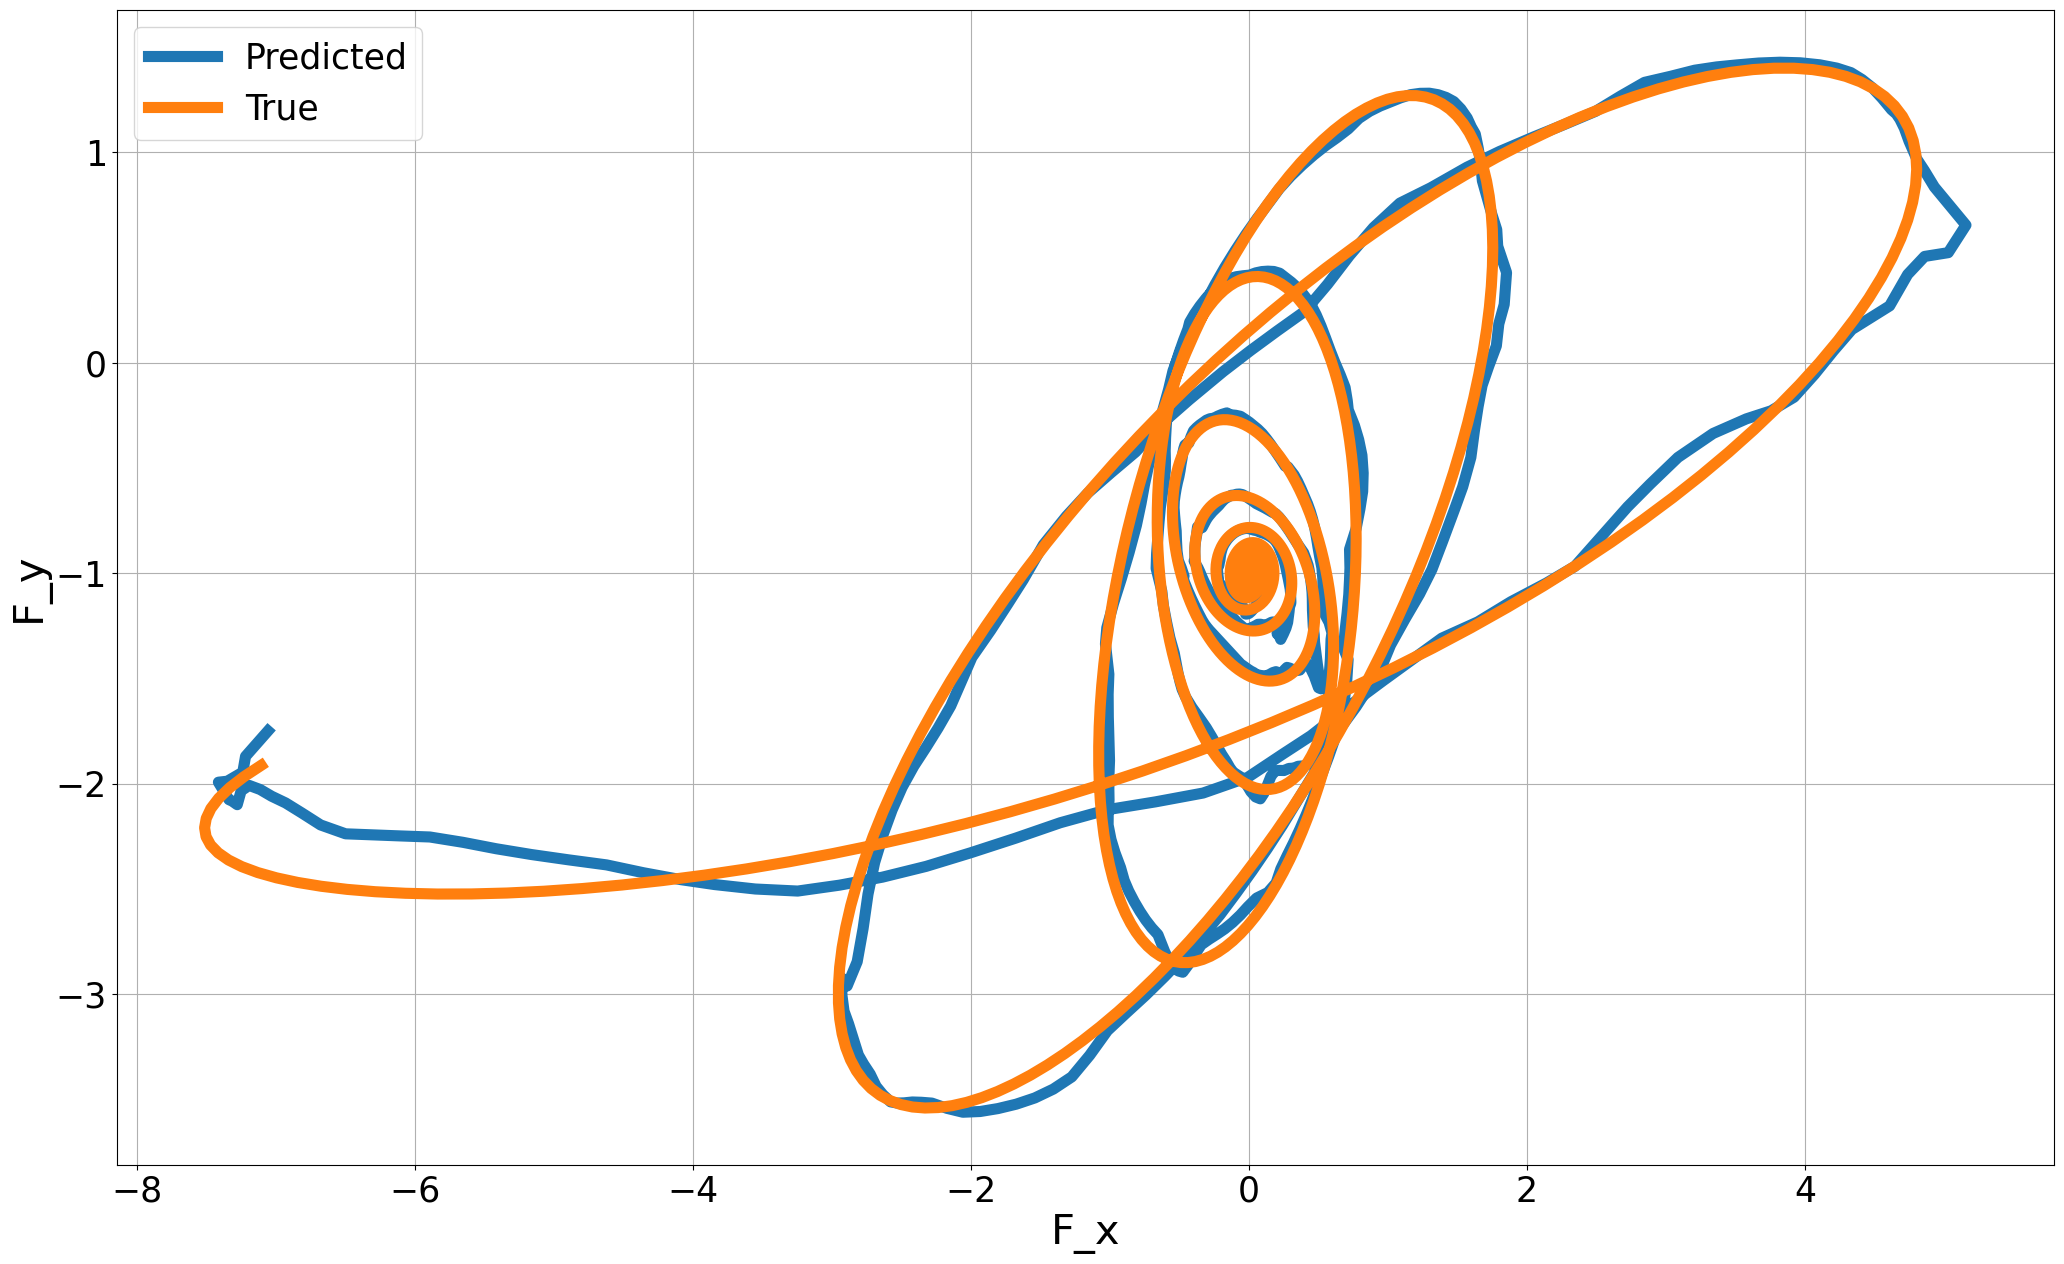

In [19]:
traj = 71
plot_trajectory_coord(dd, traj)

plt.savefig("FNNrobustness.png")
